In [3]:
import pandas as pd

subject_info_path = './PDGinfo.xlsx' 
subject_info_df   = pd.read_excel(subject_info_path)

display(subject_info_df.head())

,ID,Gender,Age,Height (cm),Weight (kg),BMI (kg/m2),Ortho-Prosthesis,Years of formal study,Disease duration (years),L-Dopa equivalent units (mg•day-1),...,OFF - Stroop-I time (s),OFF - Stroop-I error,OFF - Stroop-II time (s),OFF - Stroop-II error,OFF - Stroop-III time (s),OFF - Stroop-III error,OFF - TMTA time (s),OFF - TMTA error,OFF - TMTB time(s),OFF - TMTB error
0,SUB01,M,58,168.0,69.00,24.447279,No,11,20,1300,...,17,0,15,0,20,2,34.16,0,110,1
1,SUB02,F,53,170.0,62.55,21.643599,No,16,4,275,...,16.57,1,20,1,25,3,50,0,111,0
2,SUB03,M,69,165.0,76.50,28.099174,Corrective lens,24,1,575,...,18.17,0,22.77,0,31.5,1,30.52,0,25.78,5
3,SUB04,F,68,158.0,54.00,21.631149,Corrective lens,12,18,1400,...,-,-,-,-,-,-,-,-,-,-
4,SUB05,M,68,169.0,68.90,24.123805,No,11,19,1664,...,20,0,29,2,32,0,88,0,249,0


In [61]:
import numpy as np

def readStorageFile(filename):
    if not os.path.exists(filename):
        print('file do not exists')

    file_id = open(filename, 'r')

    # read header
    header = {}
    next_line = file_id.readline()

    while next_line.find('=') != -1:
        key, value = next_line.split('=')
        header[key] = value
        next_line = file_id.readline()

    # process column labels
    next_line = file_id.readline()
    time , labels = next_line.split()[0] , next_line.split()[1:]

    # get data
    data = []
    times = []
    next_line = file_id.readline()
    while next_line:
        t , d = next_line.split()[0] , next_line.split()[1:]
        times.append(float(t))
        data.append([float(i) for i in d])
        next_line = file_id.readline()

    file_id.close()

    return header, labels, times, np.array(data)

In [69]:
from tqdm import tqdm
import os

Synthetic_IMU_folder = './SyntheticIMU'

rigidity_label = ['ON - UPDRS-III - rigidity', 'OFF - UPDRS-III - rigidity']
subjects = subject_info_df['ID'].to_list()
On_or_Off = ['on','off']

X ,  Y = [], []

for subject in tqdm(subjects):
    for i, OnOff in enumerate(On_or_Off):
        rigidity = subject_info_df.loc[subject_info_df["ID"] == subject,rigidity_label[i]].values[0]
        if rigidity == '-': continue
            
        files = list(os.listdir(os.path.join(Synthetic_IMU_folder, subject, OnOff)))
        acc_files, gyro_files = [] , []
        for file in files:
            if file.find('acc') != -1:
                acc_files.append(file)
            elif file.find('gyro') != -1:
                gyro_files.append(file)

        assert len(acc_files) == len(gyro_files), "Length of Accelerator files and Gyroscope files are different"

        acc_files.sort()
        gyro_files.sort()

        for acc, gyro in zip(acc_files, gyro_files):
            assert acc.split('_')[:3] == gyro.split('_')[:3]
        
            
            header, labels, times, acc_data = readStorageFile(os.path.join(Synthetic_IMU_folder, subject, OnOff, acc))
            header, labels, times, gyro_data = readStorageFile(os.path.join(Synthetic_IMU_folder, subject, OnOff, gyro))

            assert acc_data.shape == gyro_data.shape

            data = np.concatenate((acc_data,gyro_data),axis=-1)
            X.append(data)
            Y.append(int(rigidity))
            # print(acc,gyro,rigidity)



# print(X.shape)
# print(Y.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:10<00:00,  2.50it/s]


In [246]:
from scipy import signal
from scipy import ndimage

new_size = 512

X_new = []
for x in X:
    ch = x.shape[1]
    new_x = np.zeros(shape=(new_size,ch))
    for i in range(ch):
        new_x[:,i] = signal.resample(x[:,i],new_size)
    X_new.append(new_x)

X_new = np.array(X_new)
    


In [253]:
from scipy import stats


def remove_outliers_zscore(X, threshold=3):
    """Removes outliers from a signal using the Z-score method."""

    original_size =X.shape[0]
    z_scores = stats.zscore(X)
    X = X[np.abs(z_scores) < threshold]
    X = signal.resample(X, original_size)
    return X

271


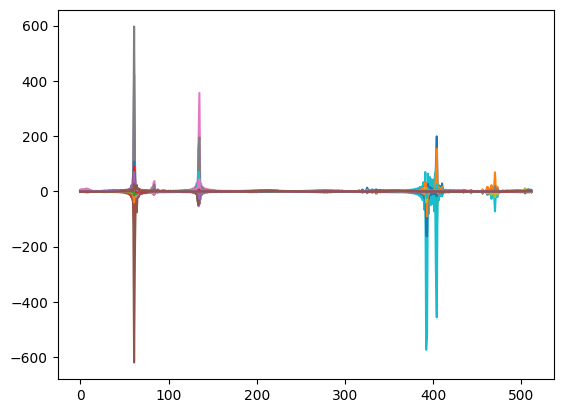

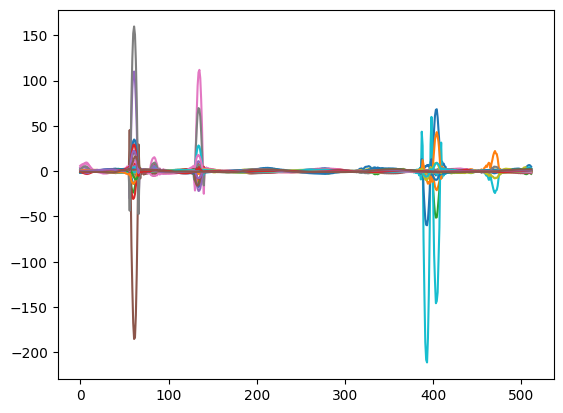

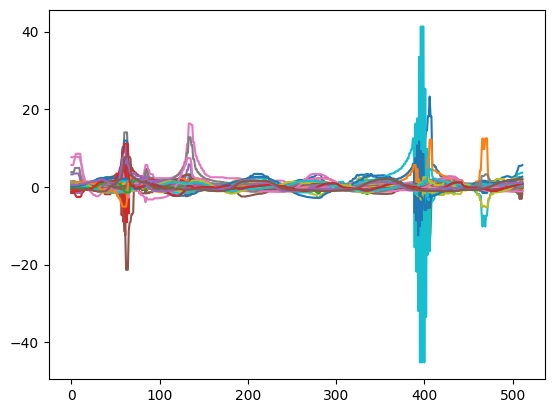

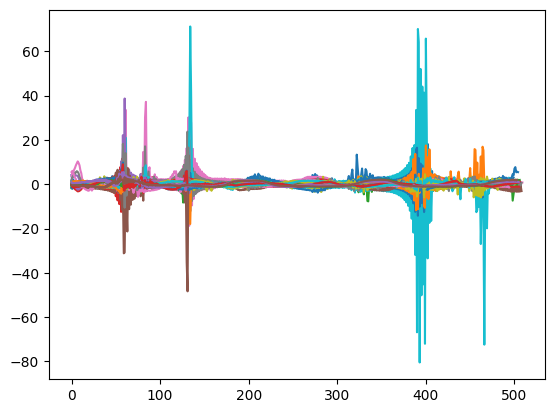

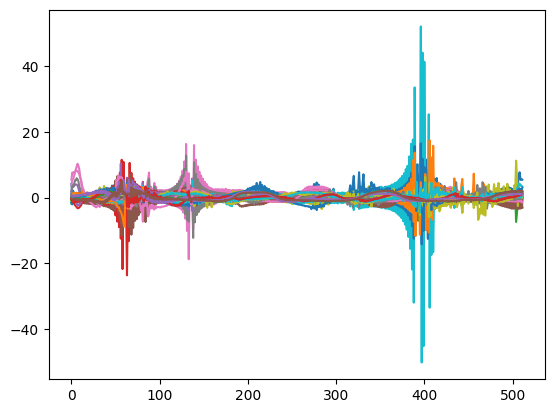

In [229]:
import matplotlib.pyplot as plt
import random
from hampel import hampel

sample = random.randint(0,X_new.shape[0]-1)
print(sample)
X_sample = X_new[sample]
for i in range(X_sample.shape[1]):
    plt.plot(X_sample[:,i])
plt.show()

window_size = 11
poly_order = 3
X_sample = X_new[sample]
for i in range(X_sample.shape[1]):
    plt.plot(signal.savgol_filter(X_sample[:,i], window_size, poly_order))
plt.show()

footprint_size = 10
X_sample = X_new[sample]
for i in range(X_sample.shape[1]):
    plt.plot(ndimage.median_filter(X_sample[:,i], footprint_size))
plt.show()

z_threshold = 2
X_sample = X_new[sample]
for i in range(X_sample.shape[1]):
    plt.plot(remove_outliers_zscore(X_sample[:,i],z_threshold))
plt.show()

window_size = 50
X_sample = X_new[sample]
for i in range(X_sample.shape[1]):
    plt.plot(hampel(X_sample[:,i],window_size).filtered_data)
plt.show()

757


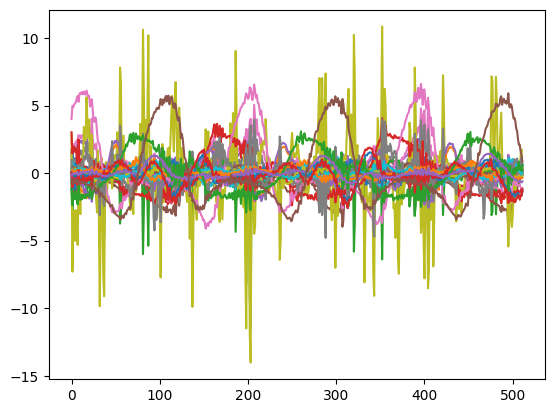

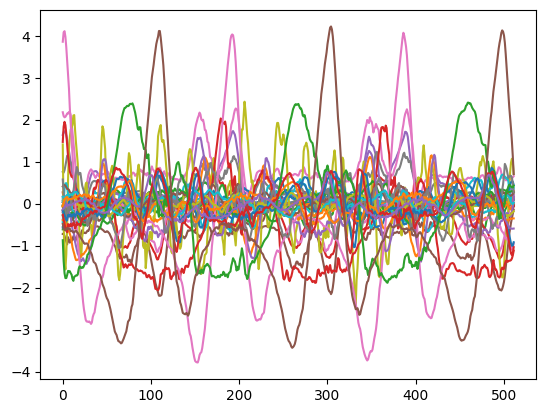

In [266]:
from functools import partial

window_size = 11
poly_order = 3
savgol_filter_partial = partial(signal.savgol_filter, window_length = window_size, polyorder = poly_order)

footprint_size = 10
median_filter_partial = partial(ndimage.median_filter, size = footprint_size)

z_threshold = 1.5
remove_outlier_partial = partial(remove_outliers_zscore , threshold=z_threshold)

def hampel_wrapper(X , window_size):
    return hampel(X,window_size).filtered_data

window_size = 50
hampel_partial = partial(hampel_wrapper,window_size =window_size)

filter_list = [hampel_partial, remove_outlier_partial, savgol_filter_partial]

sample = random.randint(0,X_new.shape[0]-1)
# sample = 294
print(sample)
X_sample = X_new[sample]
for i in range(X_sample.shape[1]):
    plt.plot(X_sample[:,i])
plt.show()

for i in range(X_sample.shape[1]):
    x = X_sample[:,i]
    for _filter in filter_list:
        x = _filter(x)
    plt.plot(x)
plt.show()


In [273]:
import random
def filter_wrapper(X, filter_list):
    for i in range(X.shape[1]):
        x = X[:,i]
        for _filter in filter_list:
            x = _filter(x)
        X[:,i] = x
        
    return X

filter_list = [hampel_partial, remove_outlier_partial, savgol_filter_partial]

filter_wrapper_partial = partial(filter_wrapper, filter_list = filter_list)

X_new_filter = np.zeros_like(X_new)
for i in tqdm(range(X_new.shape[0])):
    X_new_filter[i] = filter_wrapper_partial(X_new[i])

print(X_new_filter.shape)


100%|████████████████████████████████████████████████████████████████████████████████| 885/885 [12:08<00:00,  1.21it/s]

(885, 512, 36)


In [275]:
np.save("filtered_data.npy",{"X":X_new_filter,"y":Y})
            

In [276]:
print(np.mean(X_new),np.std(X_new))
print(np.mean(X_new_filter),np.std(X_new_filter))

-0.10852126591059268 0.6336405090389801
-0.10852126591059268 0.6336405090389801


61


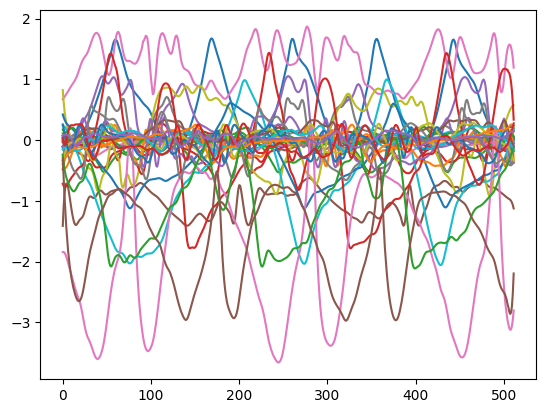

In [144]:
import random
import matplotlib.pyplot as plt
X_new_filter = data['X']

sample = random.randint(0,X_new_filter.shape[0]-1)
print(sample)
X_sample = X_new_filter[sample]
for i in range(X_sample.shape[1]):
    
    plt.plot(X_sample[:,i])
plt.show()

In [69]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

from tqdm import tqdm


class TimeSeriesDataset(Dataset):
    def __init__(self, data , label):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        _d = self.data[index]
        _l = self.label[index]
        
        normalize_d = np.zeros_like(_d,dtype=np.float16)
        for i in range(_d.shape[1]):
            normalize_d[:,i] = (_d[:,i] - np.min(_d[:,i])) / (np.max(_d[:,i]) - np.min(_d[:,i]))

        return normalize_d.transpose(1,0) , _l
        

    def __len__(self):
        return self.data.shape[0]

In [122]:


class FCN(nn.Module):
    def __init__(self, length = 1024, input_channel = 6, output_channel = 3, channels = [128,64,32], kernel_size = 3):
        super(FCN,self).__init__()
        self.channels = channels
        
        layers = []
        prev_chn = input_channel

        fcn_length = length
        for ch in channels:
            layers.append(nn.Sequential(
                nn.Conv1d(prev_chn, ch, kernel_size= kernel_size, stride = 2 , padding=1),
                nn.ReLU()
            ))
            prev_chn = ch
            fcn_length = fcn_length / 2

        self.cnn_layer = nn.Sequential(*layers)
    
        self.fc1 = nn.Linear(int(fcn_length) * channels[-1],64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,output_channel)

        self.relu = nn.ReLU()


    def forward(self,x):
        x = self.cnn_layer(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [123]:
data = np.load('filtered_data.npy',allow_pickle=True).item()

In [124]:
print(data['X'].shape)

(885, 512, 36)


In [125]:
train_split_ratio = 0.7
val_split_ratio  = 0.1
batch_size = 16
size = data['X'].shape[0]

train_size = int(size * train_split_ratio)
val_size  = int(size * val_split_ratio)

train_data , train_label = data['X'][:train_size] , data['y'][:train_size]
val_data ,   val_label   = data['X'][train_size:train_size + val_size] , data['y'][train_size: train_size + val_size]
test_data , test_label   = data['X'][train_size + val_size:] , data['y'][train_size + val_size:]

train_dataset = TimeSeriesDataset(train_data, train_label)
val_dataset   = TimeSeriesDataset(val_data,   val_label)
test_dataset  = TimeSeriesDataset(test_data,  test_label)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size = batch_size)
test_dataloader  = DataLoader(test_dataset , batch_size = batch_size)


In [136]:
model = FCN(length = 512, input_channel = 36, output_channel = 1, channels = [128,64,32], kernel_size = 3)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [137]:
def train(model, criterion , optimizer , dataloader ,device):
    model.to(device)
    model.train()
    
    running_loss = 0.
    cnt = 0
    for i, data in enumerate(dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()
    
        # Make predictions for this batch
        outputs = model(inputs)
    
        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()
    
        # Adjust learning weights
        optimizer.step()
    
        # Gather data and report
        running_loss += loss.item()
        cnt += inputs.shape[0]
        
    return running_loss / cnt 


def evaluate(model, criterion, dataloader , device):
    model.to(device)
    model.eval()
    
    running_loss = 0.
    cnt = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # Every data instance is an input + label pair
            inputs, labels = data    
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
            
            # Make predictions for this batch
            outputs = model(inputs)
        
            # Compute the loss and its gradients
            loss = criterion(outputs, labels)
        
            # Gather data and report
            running_loss += loss.item()
            cnt += inputs.shape[0]
        
    return running_loss / cnt 

In [138]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 100
eval_step = 2
for epoch in tqdm(range(epochs)):
    train_loss = train(model, criterion, optimizer, train_dataloader , device)
    print(f"Epoch:{epoch}|Train Loss:{train_loss}")

    if epoch % eval_step == 0:
        val_loss  = evaluate(model, criterion, val_dataloader, device)
        print(f"Epoch:{epoch}|Validation Loss:{val_loss}")
        

  1%|▊                                                                                 | 1/100 [00:00<01:38,  1.00it/s]

Epoch:0|Train Loss:1.0398976051749629
Epoch:0|Validation Loss:0.4886574853550304


  2%|█▋                                                                                | 2/100 [00:01<01:13,  1.33it/s]

Epoch:1|Train Loss:0.7753210067749023


  3%|██▍                                                                               | 3/100 [00:02<01:04,  1.51it/s]

Epoch:2|Train Loss:0.7991889304991493
Epoch:2|Validation Loss:0.36374613642692566


  4%|███▎                                                                              | 4/100 [00:02<00:57,  1.67it/s]

Epoch:3|Train Loss:0.7767381190483328


  5%|████                                                                              | 5/100 [00:03<00:55,  1.71it/s]

Epoch:4|Train Loss:0.7578853428460092
Epoch:4|Validation Loss:0.5562648746100339


  6%|████▉                                                                             | 6/100 [00:03<00:52,  1.79it/s]

Epoch:5|Train Loss:0.7741389263042148


  7%|█████▋                                                                            | 7/100 [00:04<00:52,  1.78it/s]

Epoch:6|Train Loss:0.7797645551900294
Epoch:6|Validation Loss:0.5548143793236125


  8%|██████▌                                                                           | 8/100 [00:04<00:50,  1.83it/s]

Epoch:7|Train Loss:0.8288886889887549


  9%|███████▍                                                                          | 9/100 [00:05<00:51,  1.78it/s]

Epoch:8|Train Loss:0.8217198883389425
Epoch:8|Validation Loss:0.8923791470852765


 10%|████████                                                                         | 10/100 [00:05<00:49,  1.82it/s]

Epoch:9|Train Loss:0.840785737954357


 11%|████████▉                                                                        | 11/100 [00:06<00:49,  1.81it/s]

Epoch:10|Train Loss:0.8312437676844189
Epoch:10|Validation Loss:0.59004976532676


 12%|█████████▋                                                                       | 12/100 [00:07<00:48,  1.82it/s]

Epoch:11|Train Loss:0.7660210329034217


 13%|██████████▌                                                                      | 13/100 [00:07<00:48,  1.79it/s]

Epoch:12|Train Loss:0.7645917154475445
Epoch:12|Validation Loss:0.4826544794169339


 14%|███████████▎                                                                     | 14/100 [00:08<00:47,  1.82it/s]

Epoch:13|Train Loss:0.7612006248295403


 15%|████████████▏                                                                    | 15/100 [00:08<00:47,  1.80it/s]

Epoch:14|Train Loss:0.7575351340705243
Epoch:14|Validation Loss:0.38694607534191827


 16%|████████████▉                                                                    | 16/100 [00:09<00:45,  1.83it/s]

Epoch:15|Train Loss:0.7698861400992497


 17%|█████████████▊                                                                   | 17/100 [00:09<00:45,  1.82it/s]

Epoch:16|Train Loss:0.7631965600230968
Epoch:16|Validation Loss:0.7624778259884227


 18%|██████████████▌                                                                  | 18/100 [00:10<00:44,  1.85it/s]

Epoch:17|Train Loss:0.788164466956513


 19%|███████████████▍                                                                 | 19/100 [00:10<00:45,  1.79it/s]

Epoch:18|Train Loss:0.7599063978826864
Epoch:18|Validation Loss:0.6872822750698436


 20%|████████████████▏                                                                | 20/100 [00:11<00:44,  1.80it/s]

Epoch:19|Train Loss:0.7969795995074443


 21%|█████████████████                                                                | 21/100 [00:12<00:45,  1.75it/s]

Epoch:20|Train Loss:0.7616878642019047
Epoch:20|Validation Loss:0.5354063402522694


 22%|█████████████████▊                                                               | 22/100 [00:12<00:43,  1.79it/s]

Epoch:21|Train Loss:0.7916065810762816


 23%|██████████████████▋                                                              | 23/100 [00:13<00:43,  1.78it/s]

Epoch:22|Train Loss:0.769026523645552
Epoch:22|Validation Loss:0.6791245178742842


 24%|███████████████████▍                                                             | 24/100 [00:13<00:42,  1.79it/s]

Epoch:23|Train Loss:0.7662262462067488


 25%|████████████████████▎                                                            | 25/100 [00:14<00:42,  1.77it/s]

Epoch:24|Train Loss:0.7671030584560264
Epoch:24|Validation Loss:0.6687530522996729


 26%|█████████████████████                                                            | 26/100 [00:14<00:41,  1.76it/s]

Epoch:25|Train Loss:0.7620040607760526


 27%|█████████████████████▊                                                           | 27/100 [00:15<00:41,  1.77it/s]

Epoch:26|Train Loss:0.7722648395667746
Epoch:26|Validation Loss:0.7012722004543651


 28%|██████████████████████▋                                                          | 28/100 [00:15<00:39,  1.82it/s]

Epoch:27|Train Loss:0.7761039055992213


 29%|███████████████████████▍                                                         | 29/100 [00:16<00:38,  1.82it/s]

Epoch:28|Train Loss:0.7661815305903963
Epoch:28|Validation Loss:0.3986311609094793


 30%|████████████████████████▎                                                        | 30/100 [00:16<00:38,  1.84it/s]

Epoch:29|Train Loss:0.7927022234496084


 31%|█████████████████████████                                                        | 31/100 [00:17<00:38,  1.81it/s]

Epoch:30|Train Loss:0.7654462850536784
Epoch:30|Validation Loss:0.4244445724920793


 32%|█████████████████████████▉                                                       | 32/100 [00:18<00:36,  1.87it/s]

Epoch:31|Train Loss:0.7661825782455419


 33%|██████████████████████████▋                                                      | 33/100 [00:18<00:36,  1.85it/s]

Epoch:32|Train Loss:0.7662331953957701
Epoch:32|Validation Loss:0.5445042144168507


 34%|███████████████████████████▌                                                     | 34/100 [00:19<00:35,  1.86it/s]

Epoch:33|Train Loss:0.765040757390332


 35%|████████████████████████████▎                                                    | 35/100 [00:19<00:35,  1.82it/s]

Epoch:34|Train Loss:0.7802149190271036
Epoch:34|Validation Loss:0.599297821521759


 36%|█████████████████████████████▏                                                   | 36/100 [00:20<00:34,  1.85it/s]

Epoch:35|Train Loss:0.764470026450704


 37%|█████████████████████████████▉                                                   | 37/100 [00:20<00:34,  1.80it/s]

Epoch:36|Train Loss:0.7897905078573643
Epoch:36|Validation Loss:0.4462295851924203


 38%|██████████████████████████████▊                                                  | 38/100 [00:21<00:34,  1.82it/s]

Epoch:37|Train Loss:0.7644966422837463


 39%|███████████████████████████████▌                                                 | 39/100 [00:21<00:34,  1.79it/s]

Epoch:38|Train Loss:0.7818410901145134
Epoch:38|Validation Loss:0.4572668509049849


 40%|████████████████████████████████▍                                                | 40/100 [00:22<00:32,  1.82it/s]

Epoch:39|Train Loss:0.7757404894358892


 41%|█████████████████████████████████▏                                               | 41/100 [00:23<00:32,  1.79it/s]

Epoch:40|Train Loss:0.7741807554765742
Epoch:40|Validation Loss:0.6326677121899345


 42%|██████████████████████████████████                                               | 42/100 [00:23<00:31,  1.83it/s]

Epoch:41|Train Loss:0.7917507010630914


 43%|██████████████████████████████████▊                                              | 43/100 [00:24<00:32,  1.78it/s]

Epoch:42|Train Loss:0.7694092359219306
Epoch:42|Validation Loss:0.4080412821336226


 44%|███████████████████████████████████▋                                             | 44/100 [00:24<00:31,  1.79it/s]

Epoch:43|Train Loss:0.7997348100572873


 45%|████████████████████████████████████▍                                            | 45/100 [00:25<00:31,  1.72it/s]

Epoch:44|Train Loss:0.796224107264702
Epoch:44|Validation Loss:0.7671261456879702


 46%|█████████████████████████████████████▎                                           | 46/100 [00:25<00:31,  1.71it/s]

Epoch:45|Train Loss:0.7658038154749955


 47%|██████████████████████████████████████                                           | 47/100 [00:26<00:31,  1.70it/s]

Epoch:46|Train Loss:0.7978087334332443
Epoch:46|Validation Loss:0.5051021223718469


 48%|██████████████████████████████████████▉                                          | 48/100 [00:27<00:30,  1.72it/s]

Epoch:47|Train Loss:0.7736365668030278


 49%|███████████████████████████████████████▋                                         | 49/100 [00:27<00:30,  1.68it/s]

Epoch:48|Train Loss:0.7654572792700304
Epoch:48|Validation Loss:0.6420676112174988


 50%|████████████████████████████████████████▌                                        | 50/100 [00:28<00:28,  1.73it/s]

Epoch:49|Train Loss:0.7984551116222326


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:28<00:28,  1.72it/s]

Epoch:50|Train Loss:0.8042636233500787
Epoch:50|Validation Loss:0.658049074086276


 52%|██████████████████████████████████████████                                       | 52/100 [00:29<00:27,  1.76it/s]

Epoch:51|Train Loss:0.7658249083936504


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:30<00:27,  1.69it/s]

Epoch:52|Train Loss:0.7527568964272593
Epoch:52|Validation Loss:0.727301838723096


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:30<00:26,  1.75it/s]

Epoch:53|Train Loss:0.7755461355403475


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:31<00:25,  1.75it/s]

Epoch:54|Train Loss:0.7714019137553522
Epoch:54|Validation Loss:0.37186165018515155


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:31<00:24,  1.80it/s]

Epoch:55|Train Loss:0.7900087883476294


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:32<00:24,  1.78it/s]

Epoch:56|Train Loss:0.7594168894895637
Epoch:56|Validation Loss:0.49735798077149823


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:32<00:23,  1.82it/s]

Epoch:57|Train Loss:0.774909632656609


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:33<00:23,  1.77it/s]

Epoch:58|Train Loss:0.7622351145705807
Epoch:58|Validation Loss:0.5527216575362466


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:33<00:21,  1.82it/s]

Epoch:59|Train Loss:0.7656564681711028


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:34<00:21,  1.78it/s]

Epoch:60|Train Loss:0.7725854124121596
Epoch:60|Validation Loss:0.521471684629267


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:35<00:21,  1.81it/s]

Epoch:61|Train Loss:0.7787402673761371


 63%|███████████████████████████████████████████████████                              | 63/100 [00:35<00:20,  1.77it/s]

Epoch:62|Train Loss:0.7857310105602653
Epoch:62|Validation Loss:0.4275056936524131


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:36<00:19,  1.80it/s]

Epoch:63|Train Loss:0.7694934265679034


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:36<00:19,  1.77it/s]

Epoch:64|Train Loss:0.7866611434492811
Epoch:64|Validation Loss:0.615264431996779


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:37<00:18,  1.79it/s]

Epoch:65|Train Loss:0.7822004496954947


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:37<00:18,  1.76it/s]

Epoch:66|Train Loss:0.7585272272877238
Epoch:66|Validation Loss:0.47289827736941253


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:38<00:18,  1.73it/s]

Epoch:67|Train Loss:0.7631641112159643


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:39<00:17,  1.73it/s]

Epoch:68|Train Loss:0.7745141701860073
Epoch:68|Validation Loss:0.4698297110470859


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:39<00:16,  1.77it/s]

Epoch:69|Train Loss:0.7993599856227203


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:40<00:16,  1.75it/s]

Epoch:70|Train Loss:0.7694649480656391
Epoch:70|Validation Loss:0.389598854563453


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:40<00:15,  1.79it/s]

Epoch:71|Train Loss:0.7663819516417668


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:41<00:15,  1.76it/s]

Epoch:72|Train Loss:0.7654126071775865
Epoch:72|Validation Loss:0.42739595608277753


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:41<00:14,  1.79it/s]

Epoch:73|Train Loss:0.7570559481619248


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:42<00:14,  1.75it/s]

Epoch:74|Train Loss:0.7608182002731595
Epoch:74|Validation Loss:0.6701925911686637


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:42<00:13,  1.79it/s]

Epoch:75|Train Loss:0.7557605533877174


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:43<00:13,  1.76it/s]

Epoch:76|Train Loss:0.7650454364030927
Epoch:76|Validation Loss:0.4983967651020397


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:44<00:12,  1.81it/s]

Epoch:77|Train Loss:0.7681050886052491


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:44<00:11,  1.79it/s]

Epoch:78|Train Loss:0.7714016060066531
Epoch:78|Validation Loss:0.6427589790387587


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:45<00:10,  1.83it/s]

Epoch:79|Train Loss:0.7860757711438254


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:45<00:10,  1.81it/s]

Epoch:80|Train Loss:0.7679394450827061
Epoch:80|Validation Loss:0.43638336116617377


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:46<00:09,  1.84it/s]

Epoch:81|Train Loss:0.763092721221135


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:46<00:09,  1.82it/s]

Epoch:82|Train Loss:0.7785557283145739
Epoch:82|Validation Loss:0.5290881476619027


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:47<00:08,  1.85it/s]

Epoch:83|Train Loss:0.7742191547338335


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:47<00:08,  1.82it/s]

Epoch:84|Train Loss:0.7639298527614365
Epoch:84|Validation Loss:0.6344556673006578


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:48<00:07,  1.87it/s]

Epoch:85|Train Loss:0.7627891469656555


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:48<00:07,  1.83it/s]

Epoch:86|Train Loss:0.7937662874939754
Epoch:86|Validation Loss:0.7191065658222545


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:49<00:06,  1.87it/s]

Epoch:87|Train Loss:0.7835478902055681


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:50<00:05,  1.84it/s]

Epoch:88|Train Loss:0.7565927493938144
Epoch:88|Validation Loss:0.3818333148956299


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:50<00:05,  1.86it/s]

Epoch:89|Train Loss:0.7724586064673009


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:51<00:04,  1.84it/s]

Epoch:90|Train Loss:0.760714483184075
Epoch:90|Validation Loss:0.525613394650546


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:51<00:04,  1.88it/s]

Epoch:91|Train Loss:0.7599941070322459


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:52<00:03,  1.84it/s]

Epoch:92|Train Loss:0.7618734740286536
Epoch:92|Validation Loss:0.4166593470356681


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:52<00:03,  1.87it/s]

Epoch:93|Train Loss:0.7527582787928173


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:53<00:02,  1.84it/s]

Epoch:94|Train Loss:0.7581034869870384
Epoch:94|Validation Loss:0.5453424209898169


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:53<00:02,  1.87it/s]

Epoch:95|Train Loss:0.7572886246664265


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:54<00:01,  1.85it/s]

Epoch:96|Train Loss:0.7552158489751123
Epoch:96|Validation Loss:0.5520034567876295


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:54<00:01,  1.88it/s]

Epoch:97|Train Loss:0.7637116204170881


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:55<00:00,  1.86it/s]

Epoch:98|Train Loss:0.7594613736203492
Epoch:98|Validation Loss:0.4735970009456981


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]

Epoch:99|Train Loss:0.7894364528008925


In [145]:
test_loss  = evaluate(model, criterion, test_dataloader, device)
print(f"Test Loss:{test_loss}")

C:\Users\USER\miniconda3\envs\crossmoda\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss:0.7090217722265908


C:\Users\USER\miniconda3\envs\crossmoda\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
